# Importing

In [1]:
import numpy as np
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import networkx as nx
import cvxpy as cp

# Constants

In [2]:
N = 10
n_i = np.array([1 for i in range(N)])
n = n_i.sum()
p = 1
q = 1
m = p + q                       

In [3]:
#np.random.seed(307)

a = np.random.uniform(0, 2, n)
# a = np.zeros(n)

b = np.random.uniform(-5, 5, n)
# b = np.zeros(n)

# c = np.random.uniform(0, 2, n)
c = np.zeros(n)
# c = np.ones(n)

# d = np.random.uniform(0, 1, n)
d = np.zeros(n)
# d = np.ones(n)

pi = np.random.uniform(0, 2, n)
# pi = np.zeros(n)

zeta = np.random.uniform(-2, 0, n)
# zeta = np.zeros(n)

gamma = np.random.uniform(-1, 1, n)
# gamma = np.zeros(n)      

delta = np.random.uniform(-2, 2, n)
# delta = np.zeros(n)

# Solving via CVXPY

In [4]:
x = cp.Variable(n)

func = 0
ineq = 0
eq = 0

for i in range(N):
    func += a[i] * x[i] ** 2 + b[i] * x[i] + c[i] * cp.logistic(d[i] * x[i])
    # func += a[i] * x[i] ** 2 + b[i] * x[i] + c[i] * cp.exp(d[i] * x[i])
    ineq += pi[i] * x[i] ** 2 + zeta[i]
    eq += gamma[i] * x[i] + delta[i]

obj = cp.Minimize(func)

constraints = [ineq <= 0,
               eq == 0,
               x >= -1,
               x <= 1]

prob = cp.Problem(obj, constraints)

In [5]:
prob.solve()

-10.62829950273889

In [6]:
x_opt = x.value
x_opt

array([-1.        , -0.23001767, -0.99999993, -0.26417911, -0.94344732,
        1.        ,  0.09149346,  0.99999999,  0.76510635, -0.89591005])

In [7]:
lambda_opt = np.array([constraints[0].dual_value, constraints[1].dual_value])
lambda_opt

array([1.91648034e-09, 2.04080617e+00])

# Network graph

In [8]:
G = nx.cycle_graph(N) # creating a graph
A = nx.to_numpy_array(G) # adjacency matrix

degrees = A.sum(axis=1)
D = np.diag(degrees)

L = D - A

# Algorithm implementation

In [9]:
def parse(x):
    cum = [0, *np.cumsum(n_i)]
    x_array = []
    for i in range(N):
        x_array.append(x[cum[i]:cum[i+1]])
        # in our case there are scalars
        # x_array.append(x[cum[i]:cum[i+1]][0])
    return np.array(x_array)

In [10]:
def f_i(i, x_i):
    return a[i] * x_i ** 2 + b[i] * x_i + c[i] * np.log(1 + np.exp(d[i] * x_i))
    # return a[i] * x_i ** 2 + b[i] * x_i + c[i] * np.exp(d[i] * x_i)

def g_i(i, x_i):
    return pi[i] * x_i ** 2 + zeta[i]

def h_i(i, x_i):
    return gamma[i] * x_i + delta[i]

In [11]:
def f(x):
    x_array = parse(x)
    return np.array([f_i(i, x_array[i]) for i in range(N)]).sum()

def g(x):
    x_array = parse(x)
    return np.array([g_i(i, x_array[i]) for i in range(N)]).sum()

def h(x):
    x_array = parse(x)
    return np.array([h_i(i, x_array[i]) for i in range(N)]).sum()

In [12]:
def grad_f_i(i, x_i):
    return 2 * a[i] * x_i + b[i] + c[i] * d[i] * np.exp(d[i] * x_i) / (1 + np.exp(d[i] * x_i))
    # return 2 * a[i] * x_i + b[i] + c[i] * d[i] * np.exp(d[i] * x_i)

def grad_g_i(i, x_i):
    return 2 * pi[i] * x_i

def grad_h_i(i, x_i):
    return gamma[i]

In [13]:
def grad_f(x):
    x_array = parse(x)
    return np.hstack(tuple([grad_f_i(i, x_array[i]) for i in range(N)]))

In [14]:
def psi_i(i, x_i):
    return np.hstack((g_i(i, x_i), h_i(i, x_i)))

def psi(x):
    x_array = parse(x)
    return np.array([psi_i(i, x_array[i]) for i in range(N)]).sum(axis=0)

In [15]:
def grad_psi_i(i, x_i):
    return np.vstack((grad_g_i(i, x_i), grad_h_i(i, x_i)))

def grad_psi(x):
    x_array = parse(x)
    return np.hstack(tuple([grad_psi_i(i, x_array[i]) for i in range(N)]))

def psi_tilde(x):
    x_array = parse(x)
    return np.hstack(tuple([psi_i(i, x_array[i]) for i in range(N)]))

def grad_psi_tilde(x):
    x_array = parse(x)
    return block_diag(*[grad_psi_i(i, x_array[i]) for i in range(N)])

In [16]:
def P_Omega_i(x_i):
    if x_i < -1:
        return -1
    elif -1 <= x_i <= 1:
        return x_i
    else:
        return 1
    
def P_Omega(x):
    x_array = parse(x)
    return np.hstack(tuple([P_Omega_i(x_array[i]) for i in range(N)]))

def P_Theta_i(lmbd_i):
    p1 = lmbd_i[0] if lmbd_i[0] >= 0 else 0
    p2 = lmbd_i[1]
    return np.array([p1, p2])

def P_Theta(lmbd):
    return np.hstack(tuple([P_Theta_i(lmbd[i:i+m]) for i in range(0, m*N, 2)]))

In [17]:
def eps(k):
    return np.array([1 / np.exp(0.01 * (k+1)) for _ in range(N)])
    # return np.array([10 / (k+1)**2 for _ in range(N)])

In [18]:
# event-triggered mechanism

def ETDOA(alpha, beta, x0, lmbd0, s0, n_iter):

    xm1 = x0
    lmbdm1 = lmbd0

    x_k = np.zeros((n_iter, n))
    lmbd_k = np.zeros((n_iter, m*N))
    lmbd_tilde_k = np.zeros((n_iter, m*N))
    s_k = np.zeros((n_iter, m*N))

    x_k[0] = xm1
    x_k[1] = x0

    lmbd_k[0] = lmbdm1
    lmbd_k[1] = lmbd0

    lmbd_tilde_k[1] = lmbd0

    s_k[1] = s0

    C = np.zeros((n_iter, N)) # communication numbers
    C[1] = np.ones(N)

    k = 1

    while k <= n_iter-2:

        # updates
        x_k[k+1] = P_Omega(x_k[k] - 2 * alpha * (grad_f(x_k[k]) + grad_psi_tilde(x_k[k]).T @ lmbd_k[k]) + alpha * (grad_f(x_k[k-1]) + grad_psi_tilde(x_k[k-1]).T @ lmbd_k[k-1]))
        lmbd_k[k+1] = P_Theta(lmbd_k[k] + 2 * alpha * psi_tilde(x_k[k]) - alpha * psi_tilde(x_k[k-1]) - alpha * s_k[k] - alpha * beta * np.kron(L, np.identity(m)) @ lmbd_tilde_k[k])
        
        # test the event-triggered rule
        for i, j in zip(range(0, m*N, m), range(N)):
            if np.linalg.norm(lmbd_tilde_k[k][i:i+m] - lmbd_k[k][i:i+m]) > eps(k)[j]:
                C[k+1][j] = C[k][j] + 1
                lmbd_tilde_k[k+1][i:i+m] = lmbd_k[k+1][i:i+m]
            else:
                C[k+1][j] = C[k][j]
                lmbd_tilde_k[k+1][i:i+m] = lmbd_tilde_k[k][i:i+m]
        
        # update the local update
        s_k[k+1] = s_k[k] + beta * np.kron(L, np.identity(m)) @ lmbd_tilde_k[k+1]
    
        k = k + 1
    
    return x_k, C

In [19]:
# periodic communication

def PDOA(alpha, beta, x0, lmbd0, s0, n_iter):

    xm1 = x0
    lmbdm1 = lmbd0

    x_k = np.zeros((n_iter, n))
    lmbd_k = np.zeros((n_iter, m*N))
    s_k = np.zeros((n_iter, m*N))

    x_k[0] = xm1
    x_k[1] = x0

    lmbd_k[0] = lmbdm1
    lmbd_k[1] = lmbd0

    s_k[1] = s0

    C = np.zeros((n_iter, N)) # communication numbers
    C[1] = np.ones(N)

    k = 1

    while k <= n_iter-2:

        # updates
        x_k[k+1] = P_Omega(x_k[k] - 2 * alpha * (grad_f(x_k[k]) + grad_psi_tilde(x_k[k]).T @ lmbd_k[k]) + alpha * (grad_f(x_k[k-1]) + grad_psi_tilde(x_k[k-1]).T @ lmbd_k[k-1]))
        lmbd_k[k+1] = P_Theta(lmbd_k[k] + 2 * alpha * psi_tilde(x_k[k]) - alpha * psi_tilde(x_k[k-1]) - alpha * s_k[k] - alpha * beta * np.kron(L, np.identity(m)) @ lmbd_k[k])
        # update the local update
        s_k[k+1] = s_k[k] + beta * np.kron(L, np.identity(m)) @ lmbd_k[k+1]
    
        C[k+1] = C[k] + np.ones(N)

        k = k + 1
    
    return x_k, C

# Numerical experiment

In [20]:
# step sizes

# alpha = 0.15
# beta = 1.2

k_c = 1

alpha = 1 / 2 * 1 / (3 * k_c)
beta = 1 / 2 * (1 - 3 * alpha * k_c) / (alpha * np.linalg.eigvals(L).max())

print(f"alpha = {alpha}, beta = {beta}")

alpha = 0.16666666666666666, beta = 0.37499999999999983


In [21]:
x_k_ET, C_ET = ETDOA(alpha=alpha, beta=beta, x0=np.zeros(n), lmbd0=np.zeros(m*N), s0=np.zeros(m*N), n_iter=2000)
x_k_P, C_P = PDOA(alpha=alpha, beta=beta, x0=np.zeros(n), lmbd0=np.zeros(m*N), s0=np.zeros(m*N), n_iter=2000)

In [22]:
C_s = [int(x) for x in C_ET.mean(axis=1)]
current = 0
x_k_unique = []

for x_k, C in zip(x_k_ET, C_s):
    if C > current:
        current = C
        x_k_unique.append(x_k)
    else:
        continue

C_s_unique = list(set(C_s[1:]))

Text(0, 0.5, 'Squared error')

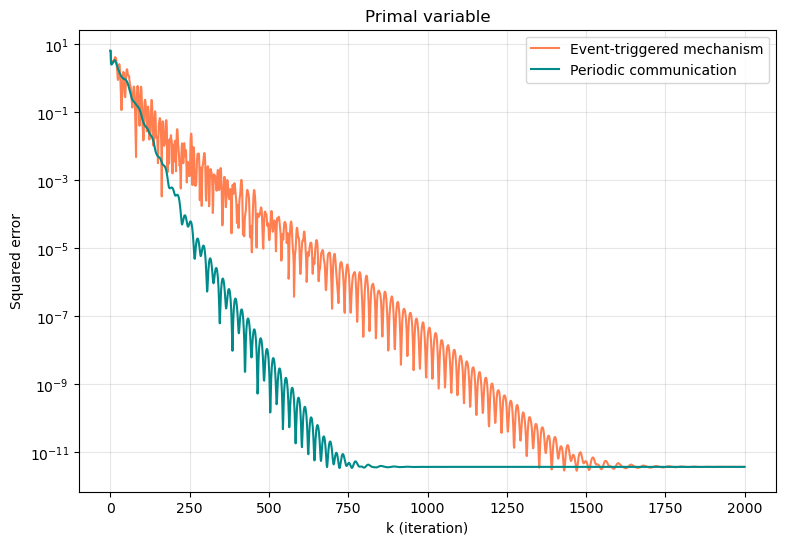

In [23]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_ET.shape[0]), [np.linalg.norm(x_k_ET[k] - x_opt)**2 for k in range(x_k_ET.shape[0])], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(x_k_P.shape[0]), [np.linalg.norm(x_k_P[k] - x_opt)**2 for k in range(x_k_P.shape[0])], color = 'darkcyan', label="Periodic communication")

#plt.xlim(0, 100)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("k (iteration)")
plt.ylabel("Squared error")

Text(0, 0.5, '$|f(x_k) - f(x^*)|$')

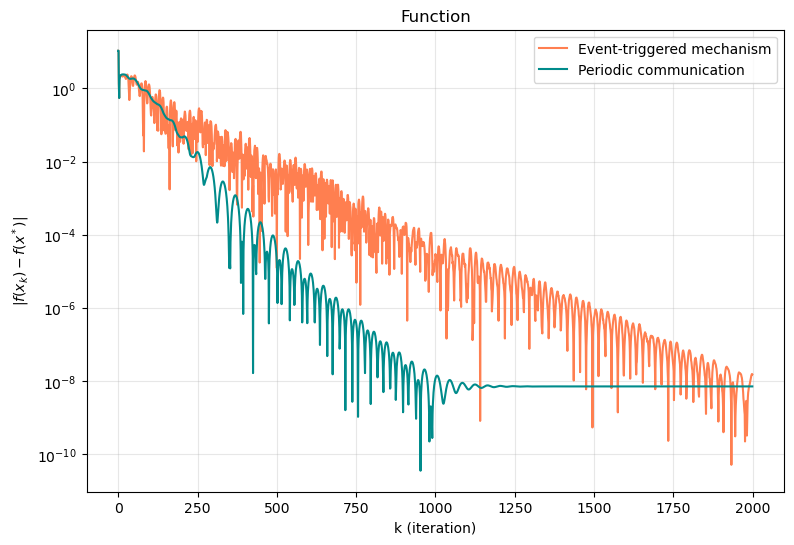

In [24]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_ET.shape[0]), [abs(f(x_k_ET[k]) - f(x_opt)) for k in range(x_k_ET.shape[0])], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(x_k_P.shape[0]), [abs(f(x_k_P[k]) - f(x_opt)) for k in range(x_k_P.shape[0])], color = 'darkcyan', label="Periodic communication")

#plt.xlim(0, 100)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Function")
plt.xlabel("k (iteration)")
plt.ylabel("$|f(x_k) - f(x^*)|$")

(1e-12, 100000.0)

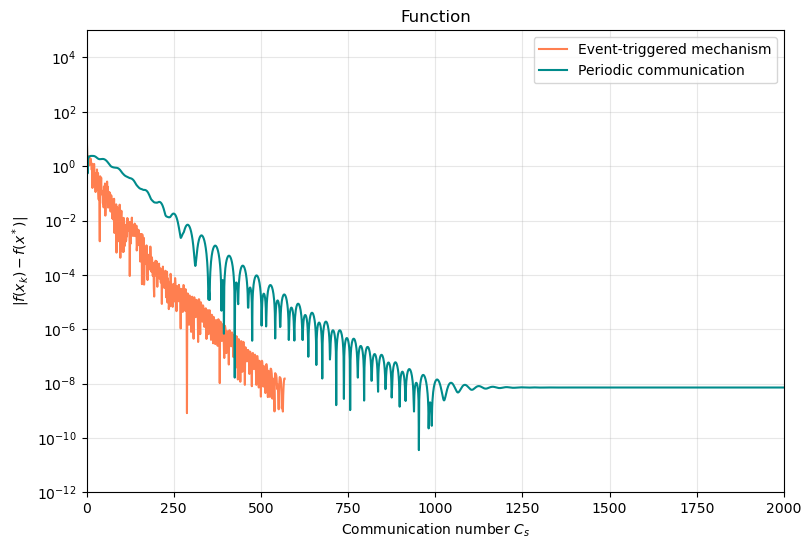

In [25]:
plt.figure(figsize=(9, 6))

plt.plot(C_s_unique, [abs(f(x_k_unique[k]) - f(x_opt)) for k in range(len(x_k_unique))], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(x_k_P.shape[0]), [abs(f(x_k_P[k]) - f(x_opt)) for k in range(x_k_P.shape[0])], color = 'darkcyan', label="Periodic communication")


plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Function")
plt.xlabel("Communication number $C_s$")
plt.ylabel("$|f(x_k) - f(x^*)|$")
plt.xlim(0, 2000)
plt.ylim(1e-12, 1e5)

# Alghunaim problem

## Constants

In [26]:
K = 20
Q_k = 10

N = K
n_i = np.array([Q_k for _ in range(N)])
n = n_i.sum()
p = 0
q = K
m = p + q

R_array = []
for k in range(K):
    #R_k = np.random.randn(Q_k, Q_k)
    #R_k = R_k.T @ R_k
    #R_k = 2 * np.diag(np.ones(Q_k), k = 0) + np.diag(np.ones(Q_k-1), k = 1) + np.diag(np.ones(Q_k-1), k = -1)
    #ev = np.linalg.eigvals(R_k)
    #eva = [abs(x) for x in ev]
    #print(max(eva) - min(eva))
    R_k = 1.5 * np.identity(Q_k)
    R_array.append(R_k)

R_array = np.array(R_array)


r_array = []
for k in range(K):
    r_k = np.random.randint(low = -2, high = 3, size = Q_k)
    r_array.append(r_k)
    

b_e = np.random.randint(low = -1, high = 2, size = K)

In [27]:
S_e = 1

G = [[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

G = np.array(G)

degrees = G.sum(axis=1)
D = np.diag(degrees)

L = D - G

G_I = G + np.identity(K)

B_matrix = []
for e in range(K):
    B_array = []
    for k in range(K):
        if k in np.nonzero(G_I[e])[0]:
            B_ek = np.random.randint(low = -2, high = 3, size = (S_e, Q_k))
            B_array.append(B_ek)
        else: 
            B_array.append(np.zeros((S_e, Q_k)))
            
    B_matrix.append(B_array)

In [28]:
S_e = 20

# переделываем ограничение, теперь оно одно:
B_stack_matrix = []
for k in range(K):
    B_stack_matrix.append(np.vstack(tuple([B_matrix[e][k] for e in range(K)])))

## Solving via CVXPY

In [29]:
w = cp.Variable(Q_k*K)

R = block_diag(*R_array)
r = np.hstack(tuple(r_array))

func = cp.quad_form(w, R) + r @ w

constraints = [w >= -1,
               w <= 1]

for e in range(K):
    constraints.append(np.hstack(tuple(B_matrix[e])) @ w == b_e[e])

obj = cp.Minimize(func)

prob = cp.Problem(obj, constraints)
prob.solve()
w_opt = w.value

## Creating functions

In [30]:
def f_i(i, x_i):
    return x_i @ R_array[i] @ x_i + r_array[i] @ x_i

def h_i(i, x_i):
    return B_stack_matrix[i] @ x_i - 1/K * b_e

In [31]:
def grad_f_i(i, x_i):
    return 2 * R_array[i] @ x_i + r_array[i]

def grad_h_i(i, x_i):
    return B_stack_matrix[i]

In [32]:
def f(x):
    x_array = parse(x)
    return np.array([f_i(i, x_array[i]) for i in range(N)]).sum()

def h(x):
    x_array = parse(x)
    return np.array([h_i(i, x_array[i]) for i in range(N)]).sum(axis=1)

In [33]:
def grad_f(x):
    x_array = parse(x)
    return np.hstack(tuple([grad_f_i(i, x_array[i]) for i in range(N)]))

In [34]:
def psi_i(i, x_i):
    return h_i(i, x_i)

def psi(x):
    x_array = parse(x)
    return np.array([psi_i(i, x_array[i]) for i in range(N)]).sum(axis=1)

In [35]:
def grad_psi_i(i, x_i):
    return grad_h_i(i, x_i)

def grad_psi(x):
    x_array = parse(x)
    return np.hstack(tuple([grad_psi_i(i, x_array[i]) for i in range(N)]))

def psi_tilde(x):
    x_array = parse(x)
    return np.hstack(tuple([psi_i(i, x_array[i]) for i in range(N)]))

def grad_psi_tilde(x):
    x_array = parse(x)
    return block_diag(*[grad_psi_i(i, x_array[i]) for i in range(N)])

In [36]:
def P_Omega_i(x_i):
    y = np.zeros(len(x_i))
    for i in range(len(x_i)):
        if x_i[i] < -1:
            y[i] = -1
        elif -1 <= x_i[i] <= 1:
            y[i] = x_i[i]
        elif x_i[i] > 1:
            y[i] = 1
    return y
    
def P_Omega(x):
    x_array = parse(x)
    return np.hstack(tuple([P_Omega_i(x_array[i]) for i in range(N)]))

def P_Theta_i(lmbd_i):
    return lmbd_i

def P_Theta(lmbd):
    return np.hstack(tuple([P_Theta_i(lmbd[i:i+m]) for i in range(0, m*N, m)]))

In [37]:
# step sizes

k_c = 10

alpha = 1 / 2 * 1 / (3 * k_c)
beta = 1 / 2 * (1 - 3 * alpha * k_c) / (alpha * np.linalg.eigvals(L).max())

print(f"alpha = {alpha}, beta = {beta}")

alpha = 0.016666666666666666, beta = 2.7953636974123244


In [38]:
w_i_ET, C_ET = ETDOA(alpha=alpha, beta=beta, x0=np.zeros(n), lmbd0=np.zeros(m*N), s0=np.zeros(m*N), n_iter=2000)
w_i_P, C_P = PDOA(alpha=alpha, beta=beta, x0=np.zeros(n), lmbd0=np.zeros(m*N), s0=np.zeros(m*N), n_iter=2000)

In [39]:
C_s = [int(x) for x in C_ET.mean(axis=1)]
current = 0
w_i_unique = []

for x_k, C in zip(w_i_ET, C_s):
    if C > current:
        current = C
        w_i_unique.append(x_k)
    else:
        continue

C_s_unique = list(set(C_s[1:]))

Text(0, 0.5, 'Squared error')

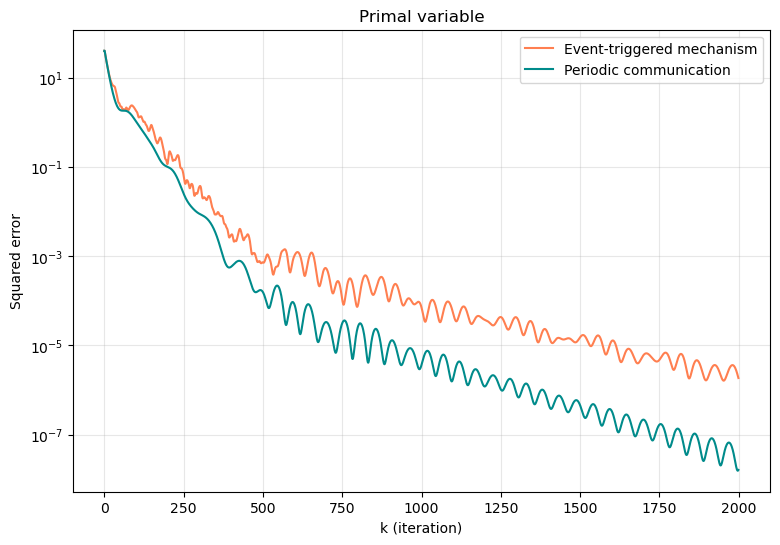

In [40]:
plt.figure(figsize=(9, 6))

plt.plot(range(w_i_ET.shape[0]), [np.linalg.norm(w_i_ET[k] - w_opt)**2 for k in range(w_i_ET.shape[0])], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(w_i_P.shape[0]), [np.linalg.norm(w_i_P[k] - w_opt)**2 for k in range(w_i_P.shape[0])], color = 'darkcyan', label="Periodic communication")

#plt.xlim(0, 100)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("k (iteration)")
plt.ylabel("Squared error")

Text(0, 0.5, '$|f(x_k) - f(x^*)|$')

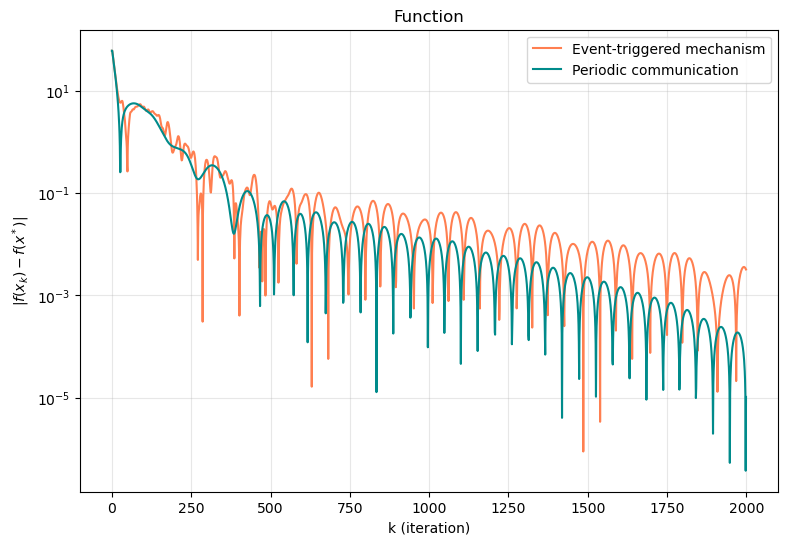

In [41]:
plt.figure(figsize=(9, 6))

plt.plot(range(w_i_ET.shape[0]), [abs(f(w_i_ET[k]) - f(w_opt)) for k in range(w_i_ET.shape[0])], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(w_i_P.shape[0]), [abs(f(w_i_P[k]) - f(w_opt)) for k in range(w_i_P.shape[0])], color = 'darkcyan', label="Periodic communication")

#plt.xlim(0, 100)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Function")
plt.xlabel("k (iteration)")
plt.ylabel("$|f(x_k) - f(x^*)|$")

Text(0, 0.5, '$|f(x_k) - f(x^*)|$')

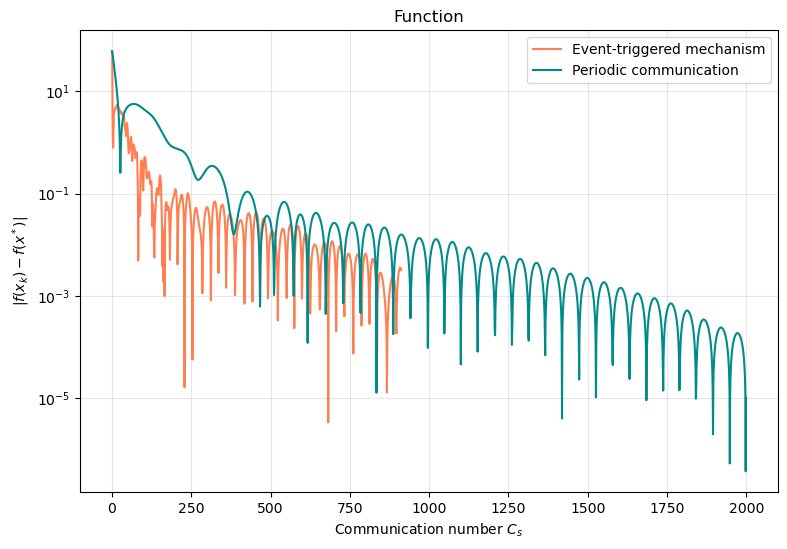

In [42]:
plt.figure(figsize=(9, 6))

plt.plot(C_s_unique, [abs(f(w_i_unique[k]) - f(w_opt)) for k in range(len(w_i_unique))], color = 'coral', label="Event-triggered mechanism")
plt.plot(range(w_i_P.shape[0]), [abs(f(w_i_P[k]) - f(w_opt)) for k in range(w_i_P.shape[0])], color = 'darkcyan', label="Periodic communication")


plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Function")
plt.xlabel("Communication number $C_s$")
plt.ylabel("$|f(x_k) - f(x^*)|$")
#plt.xlim(0, 2000)
#plt.ylim(1e-12, 1e5)